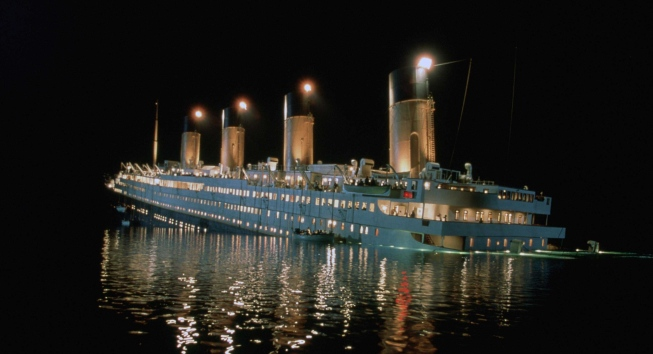
Source:FOX

In this notebook, I will explore a new library called PyCaret on the Titanic dataset and some of its powerful functions. 

In the modelling part of the Kernel, there will be 3 main parts:

       1. Normal modelling using 1 model 
       2. Blending models
       3. Stacking models

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Import the train/test set and check data 

In [ ]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')


pd.DataFrame(train.dtypes, columns=['Type'])

#  EDA

In [ ]:
train.head(10)

In [ ]:
train.describe()

Check if there is NaNs in the data

In [ ]:
train.isna().mean().round(4) * 100

In [ ]:
test.isna().mean().round(4) * 100

In [ ]:
colors = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours))

Luckily for us, the dataset is pretty clean, so we won't have to worry about dropping many features. The features with missing data are: Age, cabin (train and test), and embarked (only train). I will deal with these features differently:

1. add the median to the missing value in age (continuos)
2. drop cabin feature since it is missing a lot of data
3. use the mode for embarked (categorical) variable



In [ ]:
# create new df so we can keep the original one and manipulate a new one
train_model = train.copy()
test_model = test.copy()
#add the median for age column
train_model['Age'] = train_model['Age'].fillna(train_model['Age'].median())
test_model['Age'] = test_model['Age'].fillna(train_model['Age'].median())

#the train dataset had missing values for fare, so we will do the same but for fare feature on test set
test_model['Fare'] = test_model['Fare'].fillna(train_model['Fare'].median())

test.head(10)

Cabin has more than 77% of data missing, so we will drop this feature 

In [ ]:
train_model = train_model.drop(['Cabin'],axis=1)
test_model = test_model.drop(['Cabin'],axis=1)
test_model.head(10)

We impute the Embarket column with the most common value (mode). This way, we won't mess too much with the distribution of these features.

In [ ]:
#The test dataset didn't have missing values for Embarked, so we will apply the imputation only for the train dataset
train_model['Embarked'] = train_model['Embarked'].fillna(train_model['Embarked'].mode()[0])

train_model.isnull().mean().round(4) * 100

In [ ]:
test_model.isnull().mean().round(4) * 100

Now that our code is cleaner, we can plot some of the variables. First we will start checking the distribution of survival per fares

In [ ]:
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(10, 8))
ax = sns.violinplot(x="Survived", y="Fare", data=train_model)
ax.set_xticklabels(['no','yes']);



We see that poorer people were more likely to die. For instance, people who paid more than £300 did not die **at all** (Damn capitalism!). If you've seen the movie, it's clear that rich people had privileges. We must take it into account $ in our analysis. 


In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_model,split=True);


Another important remark is that more women survived the disaster than men. Furthermore, the survival for both men and women has a bimodal distribution: 1 peak in the distribution around 10 years old and second peak around 30 years old. Unfortunately, the distribution is almost normal for men with most of the fatalities around 30 years old. So we know that gender has an important impact in whether a person survive or not.

In [ ]:
pclass_total = train_model.groupby(['Pclass']).sum()
pclass_total = pclass_total['Survived']
plot = pclass_total.plot.pie(figsize=(8, 6),autopct='%1.1f%%')
plt.title('Percentage of survivals by class')

As we saw earlier, there were 3 different classes in the Titanic. Most of the survivals (39.8%) were from the 1st class, followed by 3rd class. However, there was more fatalities in the 3rd class because more people bought cheaper tickets tickets, so it explains why it's the second biggest percentage of survivals. 

In [ ]:
#plot distribution for weekly sales
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.distplot(train_model['Fare'])
plt.ylabel('Distribution');

 We can clearly see the graph above, which shows that most of the tickets were relatively cheap, so the 3rd class had the biggest number of survivals, but also the biggest number of fatalities. 

The Titanic stopped in 3 different ports before the tragedy. In the map below we can see where these ports were located

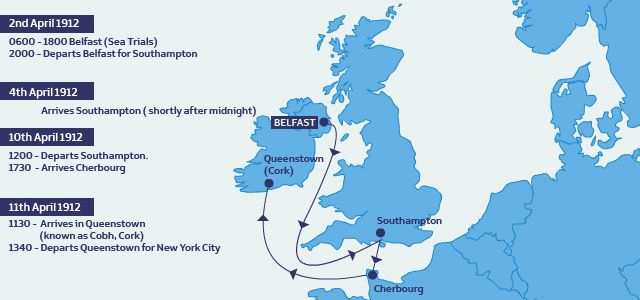
Source: [https://br.pinterest.com/pin/390616967663919768/](http://)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x="Embarked", y="Fare", hue="Survived",
                 data=train_model, palette="Set3");

C = Cherbourg, Q = Queenstown, S = Southampton

People who embarked in the Cherbourg port paid the most expensives tickets, but also were the ones who survived the most. On the other hand, people who embarked in the Queenstown port in Ireland paid the cheapest tickets and had more fatalities than survivals. Therefore, where the embarked plays an important role in the survival.

In [ ]:
def plot_bar(variable):
    rating_probs_die = pd.DataFrame(train_model[train_model.Survived == 0].groupby(variable).size().div(len(train_model)))
    rating_probs_survived = pd.DataFrame(train_model[train_model.Survived == 1].groupby(variable).size().div(len(train_model)))
    df = rating_probs_die.merge(rating_probs_survived,how='outer',left_index=True, right_index=True)
    df.columns = ['died', 'survived']
    ax = df.plot.bar(rot=0,colormap='Paired')
    
plot_bar("SibSp")    


The feature ```SibSp``` shows us the number of siblings/spouses for passengers aboard the Titanic. We can see that people who had at least 1 sibling/spouse had more chances of survival. This pattern repeats in the next analysis. 

In [ ]:
plot_bar("Parch")

In [ ]:
## Family_size seems like a good feature to create
train_model['FamilySize'] = train_model.SibSp + train_model.Parch+1
test_model['FamilySize'] = test_model.SibSp + test_model.Parch+1

plot_bar("FamilySize")  

Another interesting thing about the accident is that size of the family plays some role in the chance of survival. We see that people who were alone were 4 times more likely to die. However, if you were part of a small family (2-3 people), your chance of survival increases.

In [ ]:
## get the most important variables. 
corr = train_model.corr()**2
corr.Survived.sort_values(ascending=False)

mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,12))
sns.heatmap(train.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu', ## in order to reverse the bar replace "RdBu" with "RdBu_r"
            linewidths=.9, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20, pad = 40);

Now a classical correlation analysis. We can see that ```SibSp``` has a good correlation with Parch. 


Now with all the information, we learned from the data, you can start wondering what would be your chance of survival if you were aboard the Titanic. 
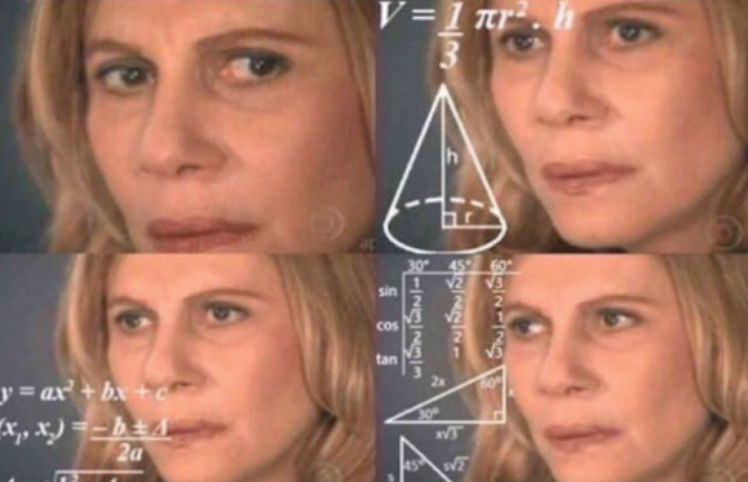

# Feature engineering

Now we can start one of the most important parts of a data science project: Feature engineering. 

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. In this section, we will apply some of the knowledge we gained in the data analysis and create some new features that could help our model performance.

In [ ]:

def has_SibSp_Parch(dataset):
    ''' this function creates a new feature if the person has 1 sibling 
    or spouse aboard the Titanic '''
    dataset['has_SibSp'] = dataset['SibSp'].apply(lambda x: 'True' if x==1 else 'False')
    dataset['has_Parch'] = dataset['Parch'].apply(lambda x: 'True' if x==1 else 'False')
    
    return dataset
    
train_model = has_SibSp_Parch(train_model)
test_model = has_SibSp_Parch(test_model)
    

One feature we can create is the passengers who had at 1 ```SibSp``` or ```Parch```. These groups survived more than the others as we saw in the analysis.

In [ ]:
## get the title from the name
train_model["title"] = [i.split('.')[0] for i in train_model.Name]
train_model["title"] = [i.split(',')[1] for i in train_model.title]

test_model["title"] = [i.split('.')[0] for i in test_model.Name]
test_model["title"] = [i.split(',')[1] for i in test_model.title]

train_model["title"].value_counts()

Each passenger had a different title (Mr., Mrs., Dr...). This is could affect whether a person would survive or not since it's linked to wealthiness. The following function will create a new feature taking into consideration the titles. We see that the most common titles are: Mr, Miss, Mrs, and Master. Each one of these will have a specific feature. The rest of the titles will be blended into a new feature called "rare".

In [ ]:
import re



def has_gender(dataset):
    ''' this function adds a new feature if it is mr, mrs, or miss. 
    It uses regular expressios in the case of Mr'''
    dataset['Mr'] = dataset['title'].apply(lambda x: 'True'  if re.search(r'Mr\b',x)  else 'False')
    dataset['Mrs'] = dataset['title'].apply(lambda x: 'True'  if 'Mrs' in x else 'False')
    dataset['Miss'] = dataset['title'].apply(lambda x: 'True'  if 'Miss' in x else 'False')
    dataset['Master'] = dataset['title'].apply(lambda x: 'True'  if 'Master' in x else 'False')
    dataset['Rare'] = dataset['title'].apply(lambda x: 'True'  if not re.search(r'Mr\b',x)  and 'Mrs' not in x and 'Miss' not in x else 'False')
    dataset = dataset.drop(['title'],axis=1)
    
    return dataset
    

train_model = has_gender(train_model)
test_model = has_gender(test_model)

We can also create a new feature called family size. However, in my tests, I observed that this feature didn't help the improvement of the model so much.

In [ ]:
def family_size(dataset):
    ''' this function creates a new feature if the person has 1 sibling 
    or spouse aboard the Titanic '''
    dataset['alone'] = dataset['FamilySize'].apply(lambda x: 'True' if x==1 else 'False')
    dataset['small_family'] = dataset['FamilySize'].apply(lambda x: 'True' if x in np.arange(2, 4) else 'False')
    dataset['big_family'] = dataset['FamilySize'].apply(lambda x: 'True' if x>=4 else 'False')
    
    return dataset

#train_model = family_size(train_model)
#test_model = family_size(test_model)

# Data Cleaning/Preparation

Finally! Our data is almost ready! Yay. Now we only need to convert the categorical variables into numerical, so our model understands the input. We will apply a technique called "One hot encoding". One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [ ]:
def clean(dataset):
    dataset = dataset.drop(['Name'],axis=1)
    dataset = dataset.drop(['PassengerId'],axis=1)
    dataset = dataset.drop(['Ticket'],axis=1)
    
    return dataset

train_model = clean(train_model)
test_model = clean(test_model)


In [ ]:
train_model = pd.get_dummies(train_model)
test_model = pd.get_dummies(test_model)

# Modelling with PyCaret 

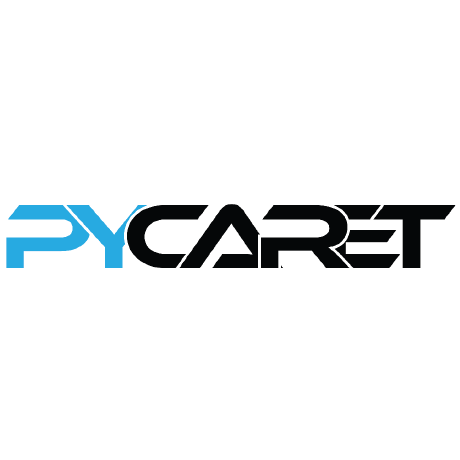

I came across this library while I was navigating in a slack for data science. It is a versatile library in which you can apply many models/tests at once. 

According to their definition: *"PyCaret is an open-source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It enables data scientists and analysts to perform iterative end-to-end data science experiments efficiently and allows them to reach conclusions faster due to far less time spent in coding."*

The library seems very similar to the caret library in R, but implemented in python. 

Installing the library 

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import * #this is not a good practice, but since we are only testing, I will import everything

The first step when using PyCaret is setting up the environment. Most of this setup part is done automatically, but you can set manually some parameters. For instance: 

* The default split ratio is 70:30, but can be changed with ```train_size```
* k-fold cross-validation is set to 10 by default 
* ```session_id``` is our classic ```random_state```

In [ ]:
model_setup = setup(data=train_model, target='Survived',session_id=1,silent = True)


The output of setup is a table with all the possible options you could've set. As you can see, the are many possibilities. It is super useful if you want to try different methods. For instance, you can use one of the feature selection options to see if the model improves. 

In [ ]:
compare_models()

The ```compare_models()``` function allows you to compare many models at once. This is for me one of the big advantages of using PyCaret. In just one line, you have a table comparison between many models. Moreover, it returns some metrics like accuracy, AUC, F1, etc. Another cool thing is how the library automatically highlights the best results.

Once you choose your model, you can create the model and then tune the model. In the next following examples, I apply both methods. 

In [ ]:
model = create_model('gbc',fold=10)

In [ ]:
tuned_model = tune_model('gbc',fold=10)

You create the model and tune it with 2 lines. However, one thing I noticed is that the tuning of the model did not improve the mean accuracy in my model overall. I checked the documentation and it says: 

***"In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross-validation."***

I show below the function which tunes the model for the ```DecisionTreeClassifier```, so we can have an idea what it does.

```
from sklearn.tree import DecisionTreeClassifier


param_grid = {"max_depth": np.random.randint(1, (len(X_train.columns)*.85),20),
              "max_features": np.random.randint(3, len(X_train.columns),20),
              "min_samples_leaf": [2,3,4,5,6],
              "criterion": ["gini", "entropy"],
                     }
```

The ```tune_model()``` function applies ```RandomizedSearchCV``` for the model taking into consideration the dataframe size. 


Now the fun part of PyCaret is that it allows you to evaluate your model performance as easy as you build the model. For me, it's a bit boring to create each of these graphs, so having an easy way to quickly evaluate my model is perfect! There are 15 different plots available. I show some options below:




In [ ]:
# plotting a model
plot_model(tuned_model,plot = 'auc')

In [ ]:
# plotting a model
plot_model(tuned_model,plot = 'feature')


In [ ]:
# plotting a model
plot_model(tuned_model,plot = 'pr')


In [ ]:
# plotting a model
plot_model(tuned_model,plot = 'confusion_matrix')

Now we can finally predict our model

In [ ]:
y_pred = predict_model(tuned_model, data=test_model)



# Blending models 

Another method that PyCaret allows us to implement is blending models. According to the documentation, ```blen_models()``` is a method of ensembling that uses consensus among estimators to generate final predictions. The idea behind blending is to combine different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome. 

We will try to see if ```blen_models()``` has any impact on our results. ```blen_models()``` can be used with some pre-defined models, which you can pass using ```estimator_list```. Furthermore, in the case of ```Classification```, method parameter can be used to define ‘soft‘ or ‘hard‘ where soft uses predicted probabilities for voting and hard uses predicted labels. For the sake of simplicity, I won't pass the list of models.

In [ ]:
# blending all models
blend_all = blend_models(method='hard')

Our mean accuracy improved a bit from 0.8301 to 0.8316. Nothing spetacular, but it's a bit of improvement.

In [ ]:
y_pred_blend = predict_model(blend_all, data=test_model)

# Stacking models

PyCaret also allows us to ```stack_models()```. In the documentation, it defines stacking models as a method of ensembling that uses meta-learning. The idea behind stacking is to build a meta-model that generates the final prediction using the prediction of multiple base estimators.

Differently than ```blen_models()```, ```stack_models()``` requires ```estimator_list()``` to be passed, so I selected some model to try this method.

In [ ]:
# create individual models for stacking

lightgbm = create_model('lightgbm')
xgboost = create_model('xgboost')
catboost = create_model('catboost')
lda = create_model('lda')
ridge = create_model('ridge')
gbc = create_model('gbc')




In [ ]:
# stacking models
stacker = stack_models(estimator_list = [lightgbm,xgboost,ridge,catboost,lda,gbc],
                       meta_model = xgboost,method='hard')

As you can see, there was no improvement in the mean accuracy compared to the 1 model method. 

In [ ]:
y_pred_stack = predict_model(stacker, data=test_model)

# Submission

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred['Label']
    })
#submission.to_csv("submission.csv", index=False)

# Change Log:

* 21/04/2020 This kernel is currently in progress, but open to feedback. 
* 22/04/2020 I finished the explanations and proof-reading.